# Stroke Prediction: A Binary Classification Problem

In this notebook, I will work on a supervised binary classification problem to predict whether a subject is a stroke patient or not. In order to do so, I will leverage three models: one linear model (Logistic Regression) and two non-linear ones (Neural Network and Random Forest).

I will engage in the following steps, chronologically:

1. [Setup: Importing Libraries and Data](#1)
2. [Exploratory Data Analysis (EDA)](#2)
3. [Data Preprocessing](#3)
4. [Feature Engineering & Selection](#4)
5. [Model Selection](#5)
6. [Model Evaluation](#6)
7. [Conclusion](#7)


## Setup: Importing Libraries and Data <a id="1"></a>

First: import all necessary dependencies.


In [184]:
%load_ext autoreload
%autoreload 2

import random
import sys
from pathlib import Path

base_path = Path().resolve().parent
sys.path.append(str(base_path))


import numpy as np
import sklearn
import torch
from loguru import logger
import pandas as pd

from src.data_preparation import load_data, min_max_normalize, StrokeDataset, replace_na, transform_non_numericals, split_X_y, create_polynomials, transform_polynomials, pca
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from src.training import BinaryLogisticRegression, BinaryNeuralNetwork, NaiveBaseline, evaluate, weighted_binary_cross_entropy_loss, k_fold_cross_validation, feature_selection, select_model
from src.data_understanding import plot_distributions, print_na, print_non_numericals, plot_scatter_and_pair, plot_relative_distributions
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In order to optimize training times, let's use the best available device, leveraging the machine's physical resources.


In [127]:
# setting parallel inference method
device = None
if torch.cuda.is_available():
    print("Using Cuda")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using MPS


In [128]:
# set seeds for sklearn, numpy, pandas

seed = 42
random.seed(seed)
np.random.seed(seed)

## Exploratory Data Analysis (EDA) <a id="2"></a>


### Data Exploration

By creating a first graphical representation of the data at hand, we can understand the underlying distributions.


In [129]:
# load data
path_data_train = "data/train.csv"
path_data_test = "data/test.csv"

data_train_raw = load_data(base_path / path_data_train)
data_test_raw = load_data(base_path / path_data_test)

data_train_raw.drop(columns=["id"], inplace=True)
data_test_raw.drop(columns=["id"], inplace=True)

2024-07-30 13:46:55.985 | SUCCESS  | src.data_preparation.data_loading:load_data:12 - Successfully created Pandas Dataframe from raw data.

2024-07-30 13:46:55.990 | SUCCESS  | src.data_preparation.data_loading:load_data:12 - Successfully created Pandas Dataframe from raw data.



Let's plot the distributions of the raw data to get an initial understanding of what we are working with.


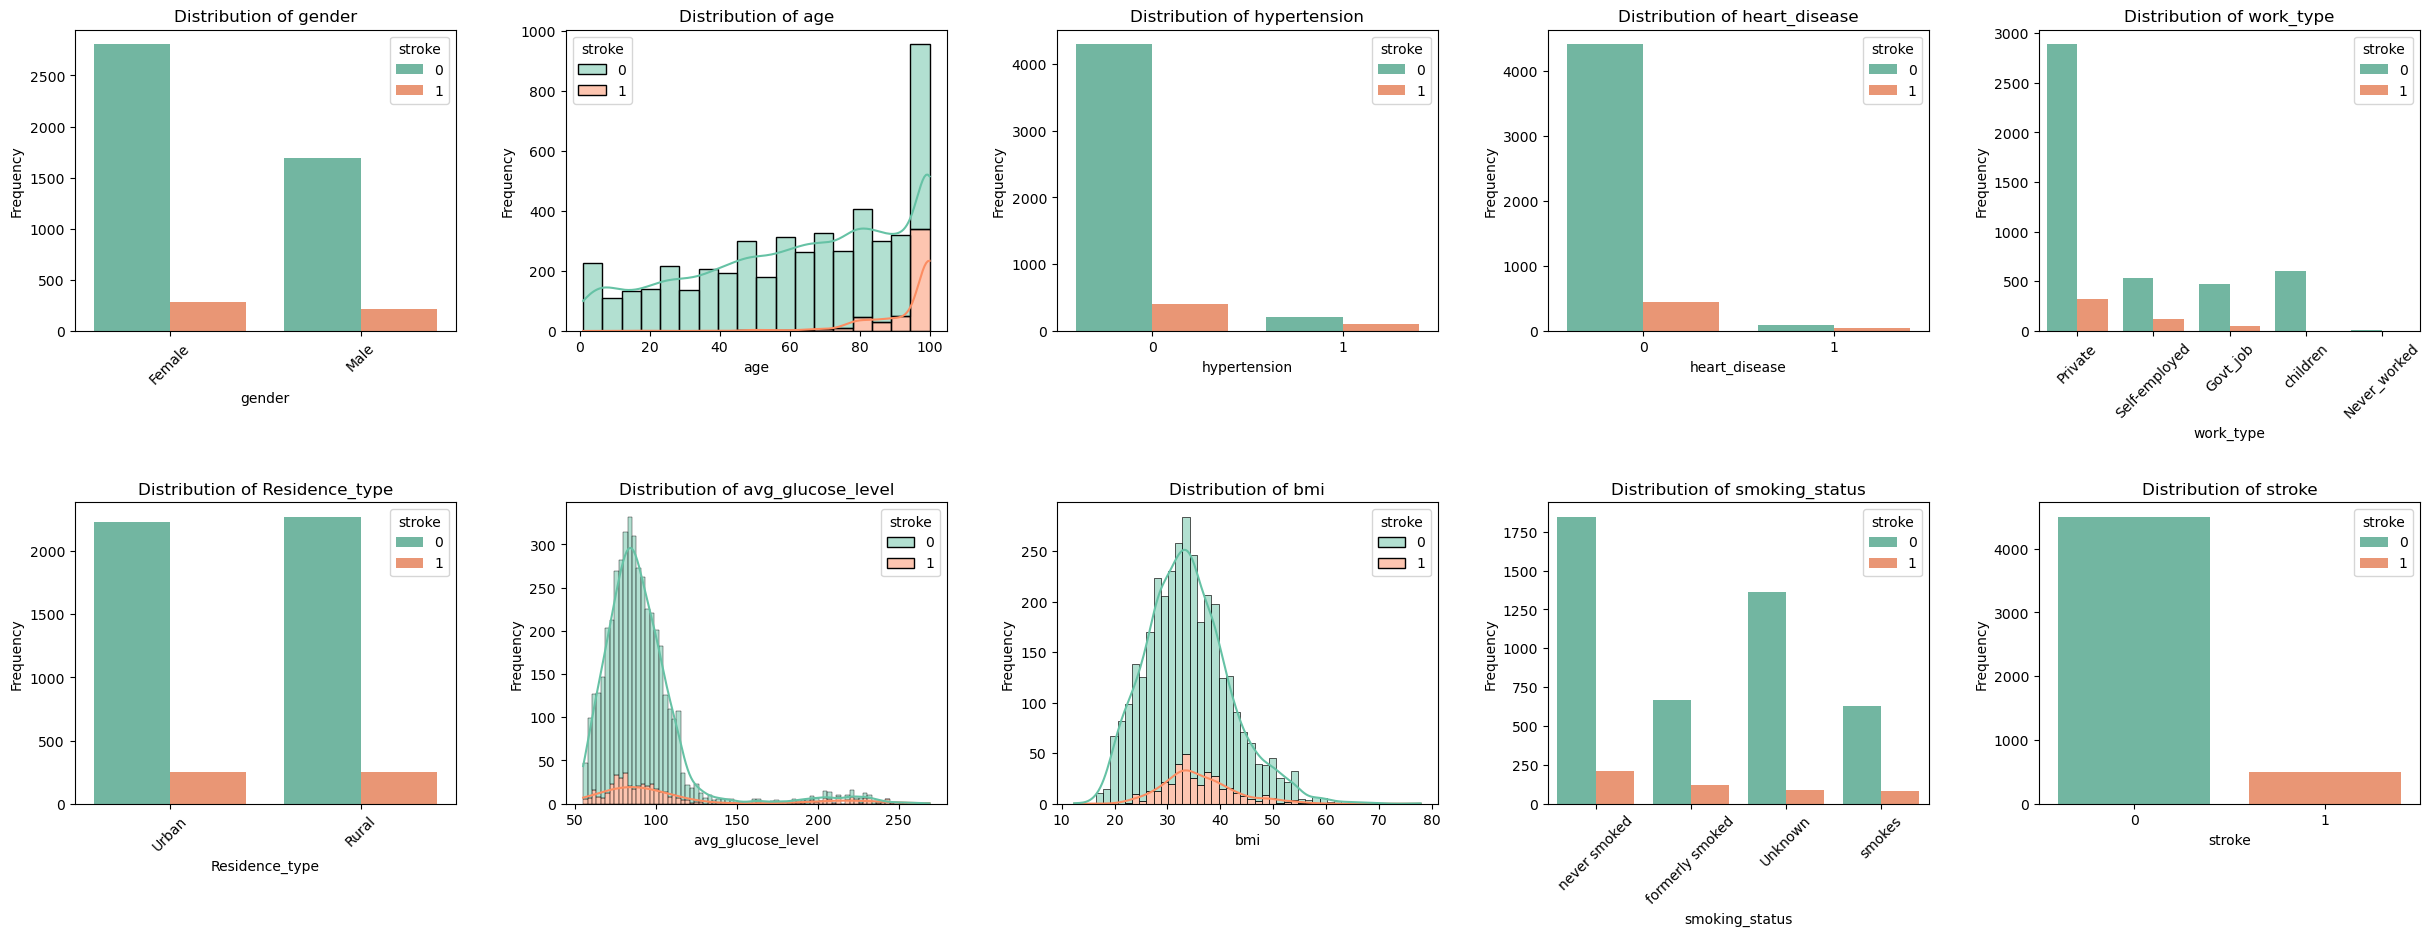

In [130]:
plot_distributions(data_train_raw)

Some important first insights:

-   The dataset is highly imbalanced: There are many more instances of people who did not have a stroke than those who did. This will require special attention during model training and evaluation.
-   We have a mix of numerical and categorical features. We will need to preprocess them accordingly.
-   Regarding the numerical features:
    -   The features have different scales. We will normalize them.
-   Regarding the categorical features:
    -   Some categorical features are binary, while others have more than two values.
    -   The categorical features with more than two values are nominal, i.e., there is no inherent order in the categories. We will one-hot encode them.
        -   Note: The `smoking_status` feature could be interpreted as ordinal in some sense ("time since last cigarette"), however, the influence of this underlying order on the target variable is not clear. We will treat it as a nominal feature.


To make sure that the training and test data come from the same underlying distribution, let's plot the test data as well.


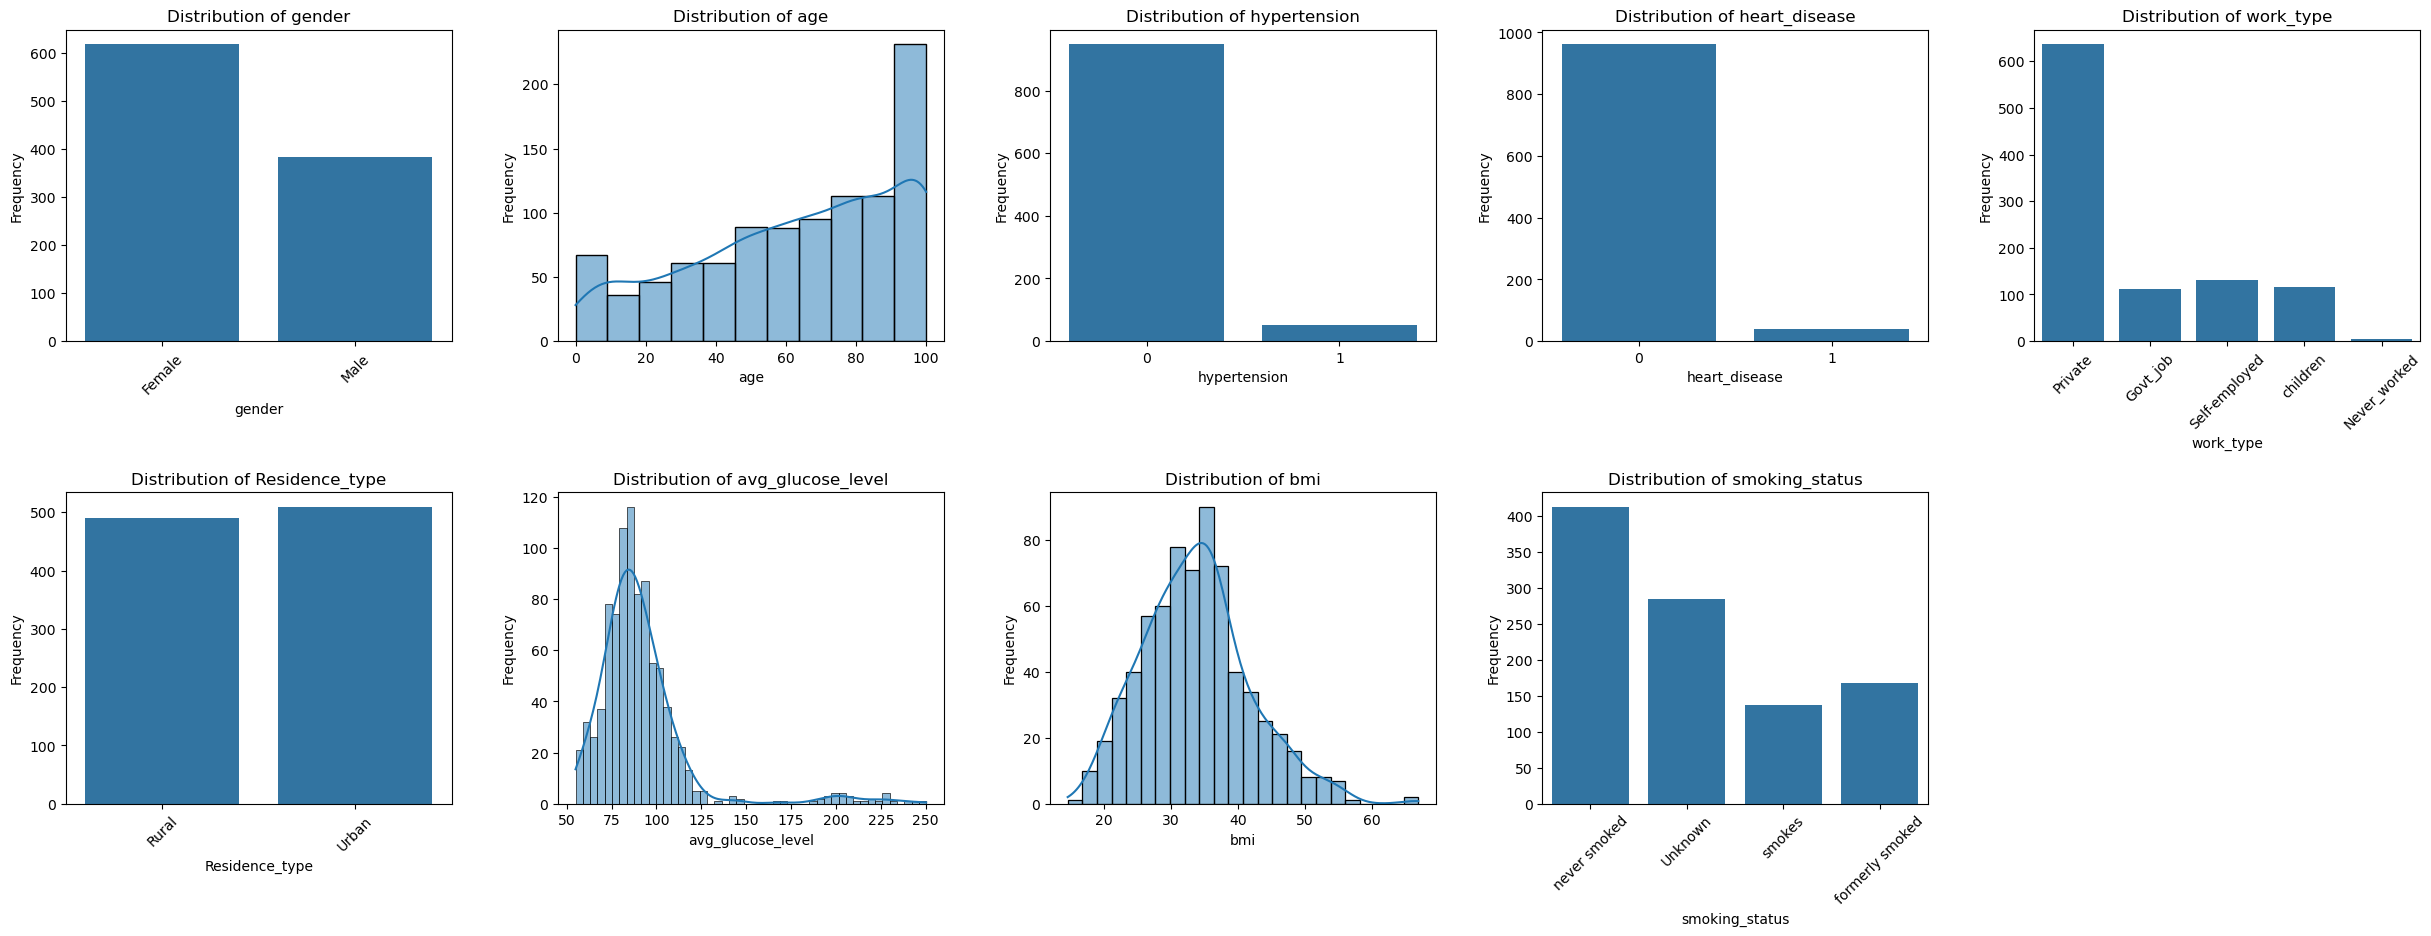

In [131]:
plot_distributions(data_test_raw)

Looking good: No significant covariate shift is apparent. The distribution of some features, such as `smoking_status` and `work_type`, may differ slightly between the training and test data, but it seems more likely our relatively small sample size creates this illusion.

Next, I'll have a look at the relative distributions of the target variable `stroke` over the features of the training data.


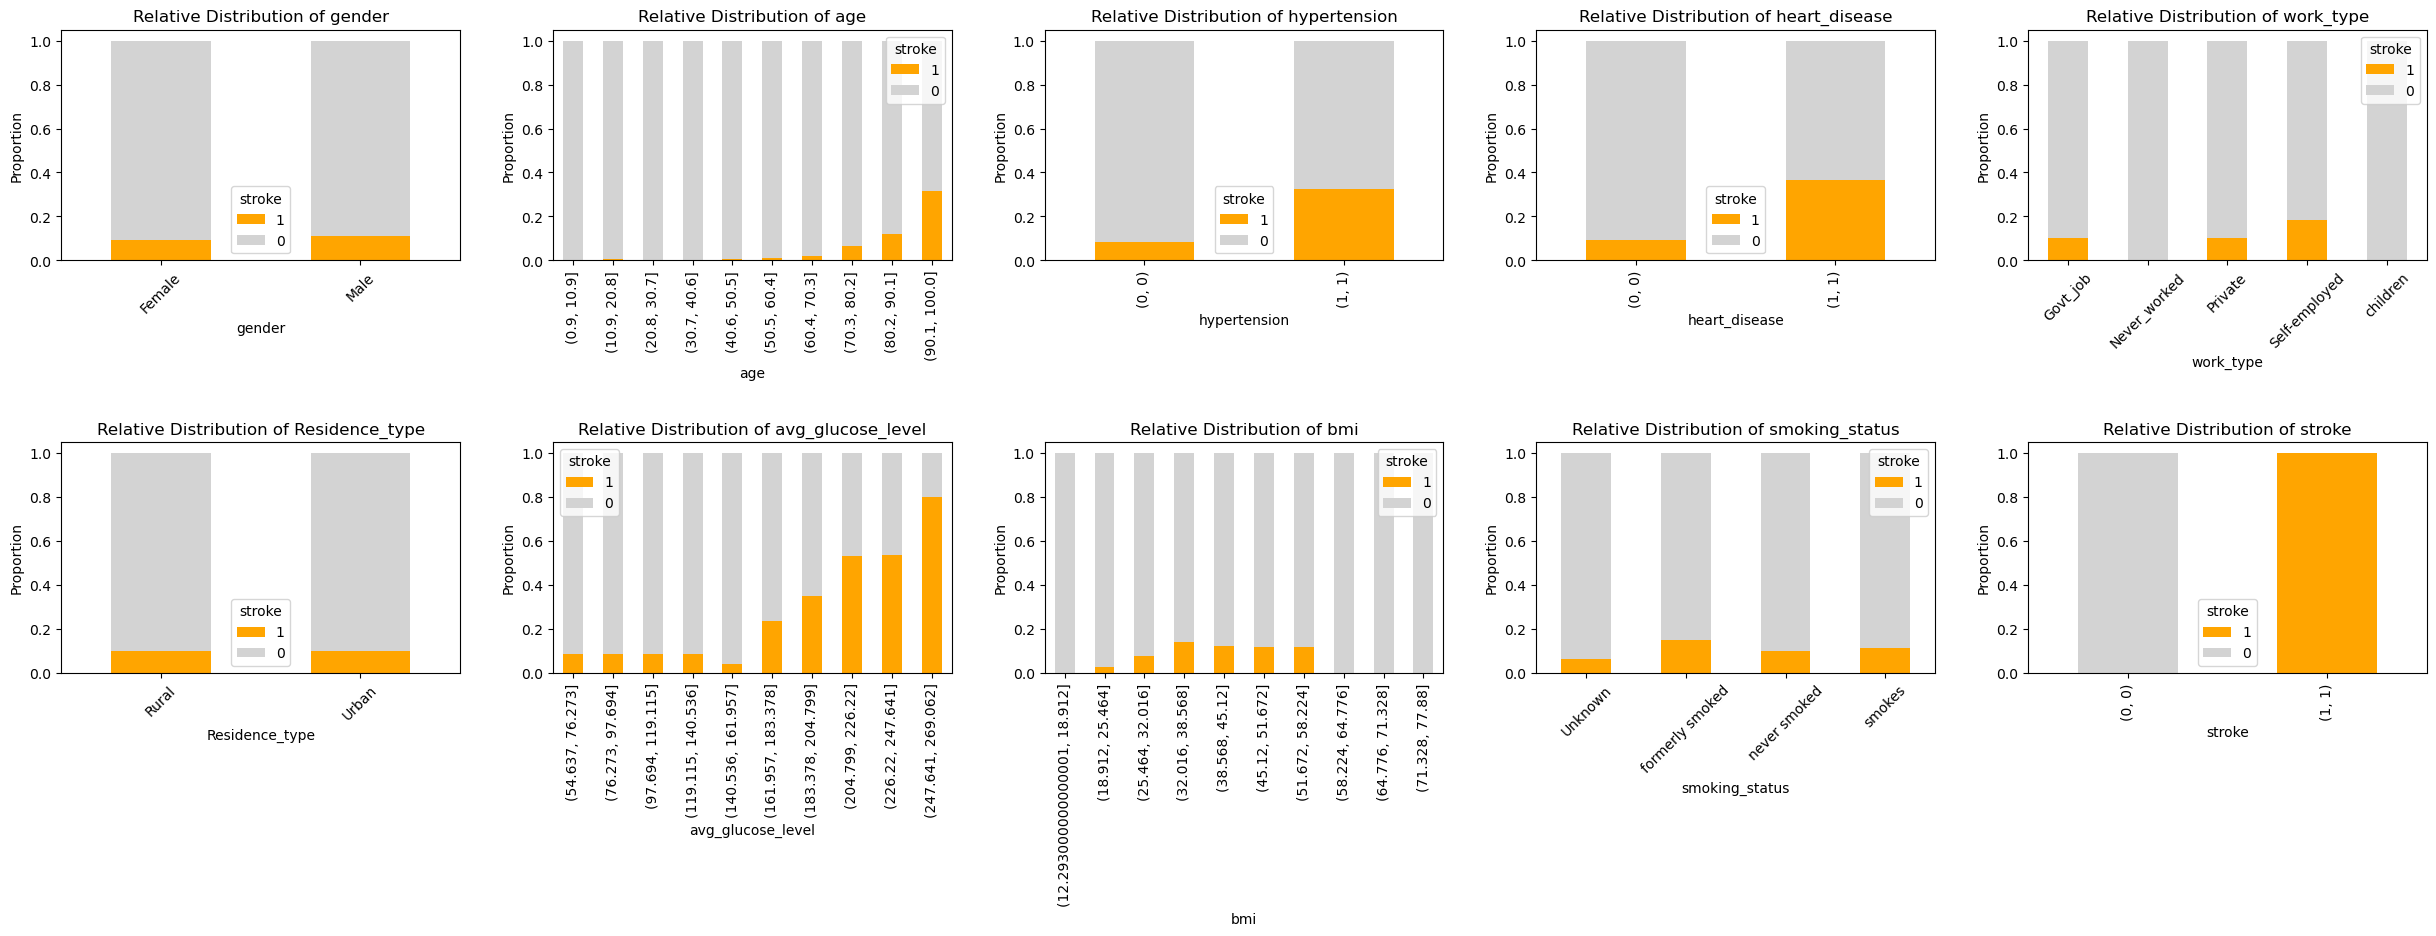

In [132]:
plot_relative_distributions(data_train_raw)

Some more important insights:

-   Regarding the continuous features:
    -   The influence of `age` and `bmi` on the likelihood of `stroke` seems to be positive and may be non-linear.
    -   `avg_glucose_level` might have a positive linear influence on the target variable, starting at a certain threshold.
-   Regarding the categorical features:
    -   `hypertension` and `heart_disease` seem to have a significant positive influence on the target variable.
    -   `work_type`: People who are self-employed seem to have a slightly higher chance of having a stroke. People who never worked or care for their children have a lower chance. Government workers and private workers seem to have a similar distribution.
    -   Both `gender` and `Residence_type` seem to have no significant influence on the target variable in isolation. However, there might be interaction effects with other features.

These are just first impressions. We did not test significance. Furthermore, we only yet looked at the features and their potential relationships with the target variable in isolation. By analyzing interaction effects later, we can get a more accurate understanding of the data and create better features for our models, which is especially important for the logistic regression model, given its linear nature.


In [133]:
print_na(data_train_raw)
print_non_numericals(data_train_raw)

2024-07-30 13:46:58.215 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column gender: 0 / 5000
2024-07-30 13:46:58.216 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column age: 0 / 5000
2024-07-30 13:46:58.216 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column hypertension: 0 / 5000
2024-07-30 13:46:58.217 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column heart_disease: 0 / 5000
2024-07-30 13:46:58.217 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column work_type: 0 / 5000
2024-07-30 13:46:58.218 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column Residence_type: 0 / 5000
2024-07-30 13:46:58.218 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column avg_glucose_leve

We can see there are a lot of missing values in our training data: 2756 / 5000 data points have at least one missing value. We will need to address this issue in the preprocessing step. Since there are so many data points with missing values, we will not simply drop those.

-   For the continuous features `avg_glucose_level` and `bmi`, we will impute the missing values with the median of the respective feature.
-   For the categorical feature `smoking_status`, the missing values currently make up a separate category called "Unknown". We will treat this category as a separate category in the one-hot encoding step.


## Data Preprocessing <a id="3"></a>


In this section, we will preprocess the data to prepare it for model training. We will:

-   Transform non-numerical features into numerical ones. This is done using one-hot encoding.
-   Replace missing values in the continuous features with the median of that respective feature.
-   Normalize the numerical features using min-max normalization. This way, all features will have the same scale, which also avoids gradient problems during neural network training.


In [134]:
data_train_preprocessed = transform_non_numericals(data_train_raw)
data_train_preprocessed = replace_na(data_train_preprocessed, replace_with="median")
data_train_preprocessed = min_max_normalize(data_train_preprocessed)

data_test_preprocessed = transform_non_numericals(data_test_raw)
data_test_preprocessed = replace_na(data_test_preprocessed, replace_with="median")
data_test_preprocessed = min_max_normalize(data_test_preprocessed)

2024-07-30 13:46:58.244 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:49 - Transformed gender into binary encoding
2024-07-30 13:46:58.246 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:53 - Transformed work_type into one-hot encoding
2024-07-30 13:46:58.247 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:49 - Transformed Residence_type into binary encoding
2024-07-30 13:46:58.248 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:53 - Transformed smoking_status into one-hot encoding
2024-07-30 13:46:58.250 | INFO     | src.data_preparation.data_preprocessing:replace_na:36 - Replaced NaN values with median
2024-07-30 13:46:58.252 | INFO     | src.data_preparation.data_preprocessing:min_max_normalize:69 - Normalized data using min-max normalization
2024-07-30 13:46:58.253 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:49 - Transformed gen

## Feature Engineering & Selection <a id="4"></a>


Next, we will create new features by combining existing ones, using polynomials and Principal Component Analysis (PCA). This way, we can map non linear-relationships between the features and the target to linear relationships, which is especially important to improve the performance of the logistic regression model.

After creating the new features, we will do some feature selection to reduce the dimensionality of the feature space. This will help avoid overfitting and reduce training times. We will then be left with the most important features, including the originals and the engineered ones.

Finally, we will plot the distribution of these residing features in relation to the target variable `stroke`, to see if the new features reveal important relationships to the target variable. We will also plot these residing features in a pair plot with the target variable to see if we can identify interaction patterns.


### Feature Engineering: Polynomial Features


We are going to create polynomial features of degree 2. This means: For each pair of features, we will create a new feature that is the product of the two features.
Example: Given features $x_1$ and $x_2$, we will end up with the following features: $x_1$, $x_2$, $x_1 x_2$, $x_1^2$, and $x_2^2$.


In [135]:
d_poly = 2

# feature cols without target
feature_columns = data_train_preprocessed.columns.drop("stroke")

polynomials_train, feature_names = create_polynomials(
    data_train_preprocessed, feature_columns, degree=d_poly
)
polynomials_test = transform_polynomials(
    data_test_preprocessed, feature_columns, feature_names
)

logger.info(f"Data preprocessed train shape: {data_train_preprocessed.shape}")
logger.info(f"Data preprocessed test shape: {data_test_preprocessed.shape}")
logger.info(f"Polynomials train shape: {polynomials_train.shape}")
logger.info(f"Polynomials test shape: {polynomials_test.shape}")

2024-07-30 13:46:58.519 | INFO     | __main__:<module>:13 - Data preprocessed train shape: (5000, 17)
2024-07-30 13:46:58.519 | INFO     | __main__:<module>:14 - Data preprocessed test shape: (1000, 16)
2024-07-30 13:46:58.520 | INFO     | __main__:<module>:15 - Polynomials train shape: (5000, 153)
2024-07-30 13:46:58.520 | INFO     | __main__:<module>:16 - Polynomials test shape: (1000, 152)


We can see that we got quite a lot more features! Those are clearly too many to include (even too many to plot!). After applying Principal Component Analysis (PCA) in the next step, we will reduce the dimensionality of the feature space. In order to avoid the "Qual der Wahl" (the agony of choice), we will simply let the Logistic Regression model decide which features are important.


In [136]:
n_pcs = 10

pcs_train = pca(polynomials_train, n_components=n_pcs)
pcs_test = pca(polynomials_test, n_components=n_pcs)

logger.info(f"Principal components train shape: {pcs_train.shape}")
logger.info(f"Principal components test shape: {pcs_test.shape}")

# data_train_engineered = data_train_preprocessed.join(pcs_train)
# data_test_engineered = data_test_preprocessed.join(pcs_test)

2024-07-30 13:46:58.667 | INFO     | __main__:<module>:6 - Principal components train shape: (5000, 10)
2024-07-30 13:46:58.668 | INFO     | __main__:<module>:7 - Principal components test shape: (1000, 10)


In order to train our Logistic Regression model on all these new features, we will need to group them together with the original features.


In [137]:
data_train_tmp = pd.concat([polynomials_train, pcs_train], axis=1)
data_test_tmp = pd.concat([polynomials_test, pcs_test], axis=1)

feature_names_tmp = data_train_tmp.drop(columns=["stroke"]).columns.to_list()

X_tmp = data_train_tmp.drop(columns=["stroke"]).copy().to_numpy()
y_tmp = data_train_tmp["stroke"].copy().to_numpy()
X_test_tmp = data_test_tmp.copy().to_numpy()

logger.info(f"First ten features in data_train_tmp: {feature_names_tmp[0:10]}")
logger.info(f"Last ten features in data_train_tmp: {feature_names_tmp[-10:]}")
logger.info(f"First ten features in data_test_tmp: {data_test_tmp.columns[0:10]}")
logger.info(f"Last ten features in data_test_tmp: {data_test_tmp.columns[-10:]}")

2024-07-30 13:46:58.725 | INFO     | __main__:<module>:10 - First ten features in data_train_tmp: ['gender', 'age', 'hypertension', 'heart_disease', 'Residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private']
2024-07-30 13:46:58.727 | INFO     | __main__:<module>:11 - Last ten features in data_train_tmp: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
2024-07-30 13:46:58.729 | INFO     | __main__:<module>:12 - First ten features in data_test_tmp: Index(['gender', 'age', 'hypertension', 'heart_disease', 'Residence_type',
       'avg_glucose_level', 'bmi', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private'],
      dtype='object')
2024-07-30 13:46:58.732 | INFO     | __main__:<module>:13 - Last ten features in data_test_tmp: Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'], dtype='object')


### Feature Selection


To select the most important features, we will train our Logistic Regression model with L2 regularization, which will force the model to set many features' weights to or close to 0, then drop the features with the weakest weights.


i = 0 – Empirical Risk Estimate: 0.2905762867317011, Previous Estimate: inf – new number of features to delete – new lowest risk estimate
i = 5 – Empirical Risk Estimate: 0.29251240639610376, Previous Estimate: 0.2905762867317011 – new number of features to delete
i = 10 – Empirical Risk Estimate: 0.2899070523028104, Previous Estimate: 0.29251240639610376 – new number of features to delete – new lowest risk estimate
i = 15 – Empirical Risk Estimate: 0.2883853490754368, Previous Estimate: 0.2899070523028104 – new number of features to delete – new lowest risk estimate
i = 20 – Empirical Risk Estimate: 0.28962558210564754, Previous Estimate: 0.2883853490754368 – new number of features to delete
i = 25 – Empirical Risk Estimate: 0.2896374123474921, Previous Estimate: 0.28962558210564754 – new number of features to delete
i = 30 – Empirical Risk Estimate: 0.29064791602328444, Previous Estimate: 0.2896374123474921 – new number of features to delete
i = 35 – Empirical Risk Estimate: 0.288563

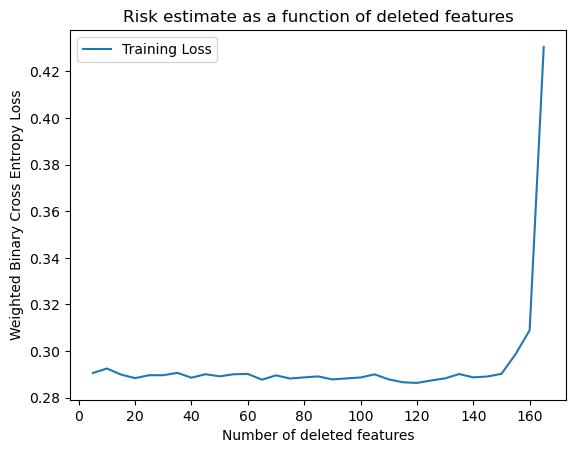

In [164]:
n_features_per_iteration = 5  # delete 5 features per iteration
risk_estimate_error_margin = 0.02  # metric: weighted binary cross entropy loss

features_to_delete, risk_estimates = feature_selection(
    X_tmp,
    y_tmp,
    n_features_per_iteration=n_features_per_iteration,
    risk_estimate_error_margin=risk_estimate_error_margin,
    plot=True,
)

Let's create new references `X_train_selected`, `X_val_selected` and `X_test_selected`.


In [142]:
# drop the features
X_selected = np.delete(X_tmp, features_to_delete, axis=1)
y_selected = y_tmp
X_test_selected = np.delete(X_test_tmp, features_to_delete, axis=1)

X_train_selected, X_val_selected, y_train_selected, y_val_selected = train_test_split(
    X_tmp, y_tmp, test_size=0.2
)

logger.info(f"Shape of X_train_tmp after feature selection: {X_train_selected.shape}")
logger.info(f"Shape of X_val_tmp after feature selection: {X_val_selected.shape}")
logger.info(f"Shape of X_test_tmp after feature selection: {X_test_selected.shape}")

2024-07-30 14:34:56.551 | INFO     | __main__:<module>:9 - Shape of X_train_tmp after feature selection: (4000, 162)
2024-07-30 14:34:56.552 | INFO     | __main__:<module>:10 - Shape of X_val_tmp after feature selection: (1000, 162)
2024-07-30 14:34:56.552 | INFO     | __main__:<module>:11 - Shape of X_test_tmp after feature selection: (1000, 70)


## Model Selection <a id="5"></a>


We arrive at the most fun part of this notebook: the model training and evaluation. For each model, we will first train the model on a manually selected set of hyperparameters and plot the learning curves and Receiver Operator Characteristic (ROC). After that, we will use nested cross-validation to optimize the hyperparameters for the model.

One exception: We will start with the baseline model, our Naive implementation. Here, no real fit is required. Each prediction is as likely to be positive as the probability of a positive class in the training data. We will use this as a baseline to compare our models against.


### Naive Baseline


2024-07-30 13:18:29.312 | INFO     | src.training.evaluate:scores:43 - Naive Baseline – Accuracy: 0.82
F1 score: 0.08163265306122448
Precision: 0.0761904761904762
Recall: 0.08791208791208792
AUC: 0.5
            Pred Neg  Pred Pos
Actual Neg       812        97
Actual Pos        83         8


Validation accuracy: 0.816


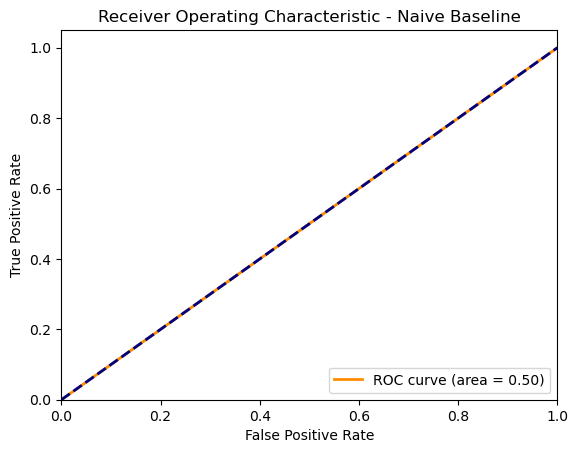

(0.82, 0.08163265306122448, 0.5)

In [51]:
# Naive Baseline
naive_baseline = NaiveBaseline()
naive_baseline.fit(X_train_selected, y_train_selected, X_val_selected, y_val_selected)
y_pred = naive_baseline.predict(X_val_selected)
y_pred_proba = naive_baseline.predict_proba(X_val_selected)
evaluate("Naive Baseline", y_val_selected, y_pred, y_pred_proba, plot=True)

The results here match expectations: The Naive Model has an Area Under the Curve (AUC) of 0.5, which means it is as good as random: The probability that a randomly positive instance gets higher output score than a randomly drawn negative instance is 50%.

Also, recall and precision are pretty low, which is expected given the random guesses of the model. The accucary is relatively high, which is simply due to the fact that the dataset is highly imbalanced: more samples are negative, so the model will predict negative more often, which results in high accuracy.

Next, we will train the Logistic Regression model on the selected features.


## Logistic Regression


### Setting Hyperparameters Manually


In [201]:
epochs = 15
learning_rate = 0.1
batch_size = 8
lambda_reg = 0.0001

Epoch 0: Train Loss: 0.3934626036594063, Val Loss: 0.2982199726980683
Epoch 1: Train Loss: 0.2918912461927347, Val Loss: 0.25571331439028866
Epoch 2: Train Loss: 0.25335189879321807, Val Loss: 0.227917014955897
Epoch 3: Train Loss: 0.22526113803864112, Val Loss: 0.20638047774693474
Epoch 4: Train Loss: 0.20303049045535781, Val Loss: 0.1887537816149674
Epoch 5: Train Loss: 0.18473871946736936, Val Loss: 0.17386832733642885
Epoch 6: Train Loss: 0.1692970297846784, Val Loss: 0.16104311365963644
Epoch 7: Train Loss: 0.1560385391123445, Val Loss: 0.14984640989548687
Epoch 8: Train Loss: 0.14452386228478403, Val Loss: 0.13998186516314115
Epoch 9: Train Loss: 0.13444095680564946, Val Loss: 0.13123196093640635
Epoch 10: Train Loss: 0.12555470937512897, Val Loss: 0.12342900171223635
Epoch 11: Train Loss: 0.11768053774058553, Val Loss: 0.11643902667874453
Epoch 12: Train Loss: 0.1106697377308178, Val Loss: 0.11015247420571142
Epoch 13: Train Loss: 0.10440037828803343, Val Loss: 0.104478186895122

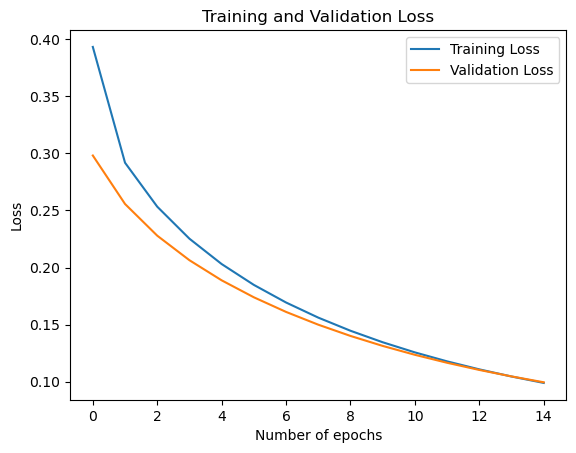

2024-07-30 15:22:03.732 | INFO     | src.training.evaluate:scores:43 - Logistic Regression – Accuracy: 0.985
F1 score: 0.9289099526066351
Precision: 0.8909090909090909
Recall: 0.9702970297029703
AUC: 0.9977973325697419
            Pred Neg  Pred Pos
Actual Neg       887        12
Actual Pos         3        98


Training complete.


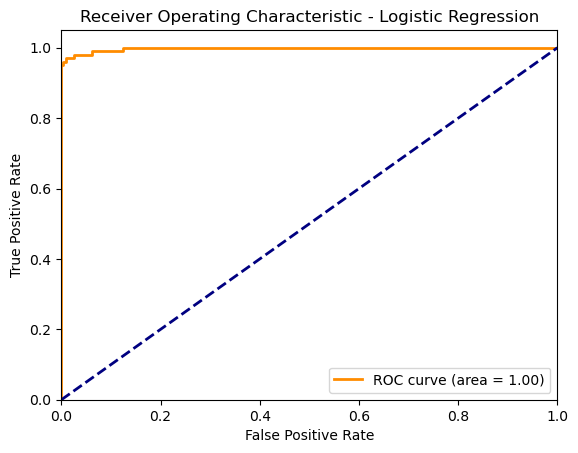

In [202]:
# Logisic Regression Hyper Param Tuning
log_reg = BinaryLogisticRegression(
    X_train_selected.shape[1],
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    lambda_reg=lambda_reg,
)

log_reg.fit(
    X_train_selected, y_train_selected, X_val_selected, y_val_selected, plot=True
)

y_pred = log_reg.predict(X_val_selected)
y_pred_proba = log_reg.predict_proba(X_val_selected)
acc, f1, auc = evaluate(
    "Logistic Regression", y_val_selected, y_pred, y_pred_proba, plot=True
)

We can see that the model learns! However, the learning curve seems to decline. This could be due to a local optimum which might be transcended with a higher learning rate. However, given the linear nature of the model, it might also be that the model is not able to capture the underlying relationships in the data, even though it is given polynomial features. If this is the case, we might further improve model performance by raising the polynomial degree, but this is out of the scope of this notebook.

Judging from the correlation matrix, we can see that the model leans towards positive predictions, which is also reflected in the relatively low precision score.

We will try varying the hyperparameters to see if we can improve model performance further. Instead of manually looking for a best set of hyperparameters, we will use the select_model function to find the best hyperparameters for us.


### Automatic Hyperparameter Tuning


In [219]:
param_grid = {
    "n_features": [X_train_selected.shape[1]],
    "epochs": [10, 20, 30],
    "learning_rate": [0.1, 0.05, 0.01],
    "lambda_reg": [0.01, 0.001, 0.0001],
}

Empirical risk estimate for fold 1 / 5, parameter set 1 / 27: 0.29199164997003973
Empirical risk estimate for fold 1 / 5, parameter set 2 / 27: 0.20657525086043066
Empirical risk estimate for fold 1 / 5, parameter set 3 / 27: 0.1914776073845333
Empirical risk estimate for fold 1 / 5, parameter set 4 / 27: 0.3042184373060742
Empirical risk estimate for fold 1 / 5, parameter set 5 / 27: 0.24679075876560666
Empirical risk estimate for fold 1 / 5, parameter set 6 / 27: 0.2379154048070732
Empirical risk estimate for fold 1 / 5, parameter set 7 / 27: 0.3531919163578
Empirical risk estimate for fold 1 / 5, parameter set 8 / 27: 0.3429217081636913
Empirical risk estimate for fold 1 / 5, parameter set 9 / 27: 0.3395586808737264
Empirical risk estimate for fold 1 / 5, parameter set 10 / 27: 0.2908254366294655
Empirical risk estimate for fold 1 / 5, parameter set 11 / 27: 0.15515784388076168
Empirical risk estimate for fold 1 / 5, parameter set 12 / 27: 0.12717731305063876
Empirical risk estimate

2024-07-30 16:20:22.731 | INFO     | src.training.evaluate:evaluate:46 - Binary Logistic Regression – Empirical Risk Estimate: 0.07173530167266721, Accuracy: 0.9975, F1 score: 0.9879518072289156, Precision: 0.9879518072289156, Recall: 0.9879518072289156, AUC: 0.999378266202887
            Pred Neg  Pred Pos
Actual Neg       716         1
Actual Pos         1        82


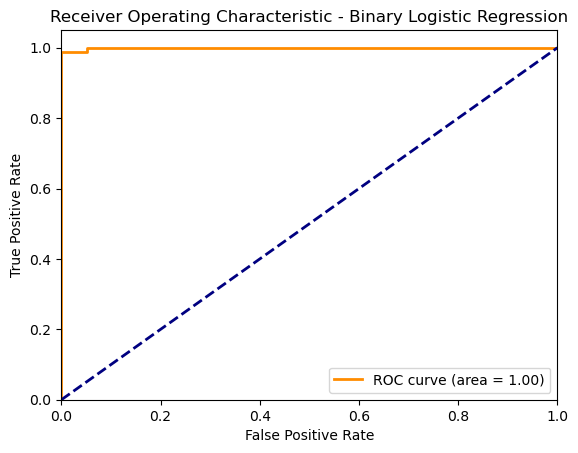

Empirical risk estimate on outer validation set: 0.07173530167266721
Epoch 0: Train Loss: 0.3934626036594063, Val Loss: 0.30363175587444435
Epoch 1: Train Loss: 0.2918912461927347, Val Loss: 0.2579020451778786
Epoch 2: Train Loss: 0.25335189879321807, Val Loss: 0.22729174226299545
Epoch 3: Train Loss: 0.22526113803864112, Val Loss: 0.2038268618698945
Epoch 4: Train Loss: 0.20303049045535781, Val Loss: 0.18491128693644104
Epoch 5: Train Loss: 0.18473871946736936, Val Loss: 0.16914551225814842
Epoch 6: Train Loss: 0.1692970297846784, Val Loss: 0.15570911065579723
Epoch 7: Train Loss: 0.1560385391123445, Val Loss: 0.14409092370293042
Epoch 8: Train Loss: 0.14452386228478403, Val Loss: 0.1339448163971348
Epoch 9: Train Loss: 0.13444095680564946, Val Loss: 0.1250187068348119
Epoch 10: Train Loss: 0.12555470937512897, Val Loss: 0.11711915198116182
Epoch 11: Train Loss: 0.11768053774058553, Val Loss: 0.11009256849978617
Epoch 12: Train Loss: 0.1106697377308178, Val Loss: 0.10381421110635598
E

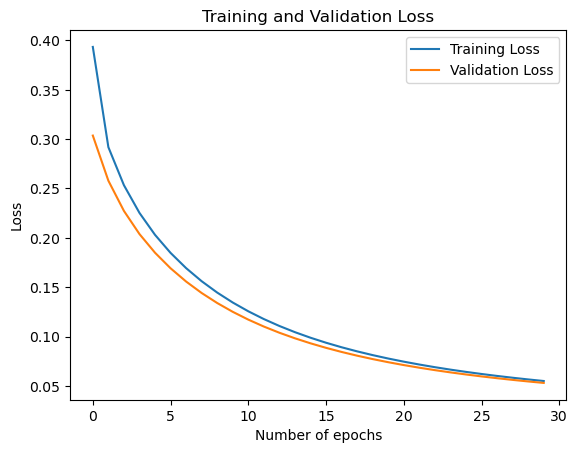

Training complete.
Fitted final model on entire dataset


In [220]:
k = 5

lr_final, lr_params, lr_R_est, lr_acc, lr_f1, lr_auc = select_model(
    X_train_selected,
    y_train_selected,
    BinaryLogisticRegression,
    param_grid,
    k=k,
)

Okay! We actually managed to find a model that is pretty good at linearly seperating the data.

The AUC is > 0.999, which is a great result. It means that given a randomly chosen positive instance will get a higher output score than a randomly chosen negative instance in 99.9% of the cases.

The precision is around 0.98, which is strong, especially given the imbalance in the dataset. It means that 98% of the positive predictions are actually positive.

The recall is around 0.98, which is also strong. It means the model is able to correctly classify 98 % of positive cases.

Let's do the same model selection and evaluation process for the Neural Network next.

## Neural Network


### Setting Hyperparameters Manually


In [210]:
epochs = 20
d_hidden = 32
n_hidden = 1
learning_rate = 0.01
batch_size = 8
lambda_reg = 0.001

Shape of self.W[1]: (162, 32)
Shape of self.B[1]: (32,)
Shape of self.W[2]: (32, 1)
Shape of self.B[2]: (1,)
Epoch 0: Train Loss: 0.595369275746551, Val Loss: 0.4932403889236775
Epoch 1: Train Loss: 0.4286089768455173, Val Loss: 0.3734146726916188
Epoch 2: Train Loss: 0.35177860723471893, Val Loss: 0.31974183004080875
Epoch 3: Train Loss: 0.3127165760291195, Val Loss: 0.2905476839041336
Epoch 4: Train Loss: 0.28670271298992994, Val Loss: 0.2691075733936044
Epoch 5: Train Loss: 0.26466892649640705, Val Loss: 0.24990436366862642
Epoch 6: Train Loss: 0.24403478982133459, Val Loss: 0.2317848240442765
Epoch 7: Train Loss: 0.22396046091991917, Val Loss: 0.21397189115760595
Epoch 8: Train Loss: 0.20435305477838092, Val Loss: 0.1966441797760114
Epoch 9: Train Loss: 0.1855991367875434, Val Loss: 0.17976735792979573
Epoch 10: Train Loss: 0.16775881512781085, Val Loss: 0.16361199018213482
Epoch 11: Train Loss: 0.15064851297880943, Val Loss: 0.14796696272781631
Epoch 12: Train Loss: 0.134608212200

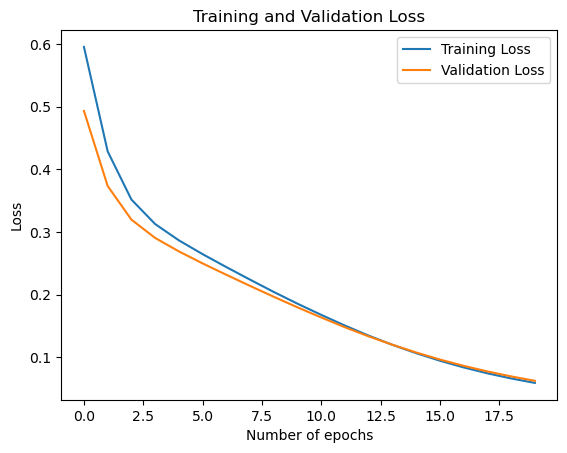

2024-07-30 15:34:43.280 | INFO     | src.training.evaluate:scores:43 - neural_net – Accuracy: 0.993
F1 score: 0.9658536585365853
Precision: 0.9519230769230769
Recall: 0.9801980198019802
AUC: 0.9995154131653432
            Pred Neg  Pred Pos
Actual Neg       894         5
Actual Pos         2        99


Training complete.


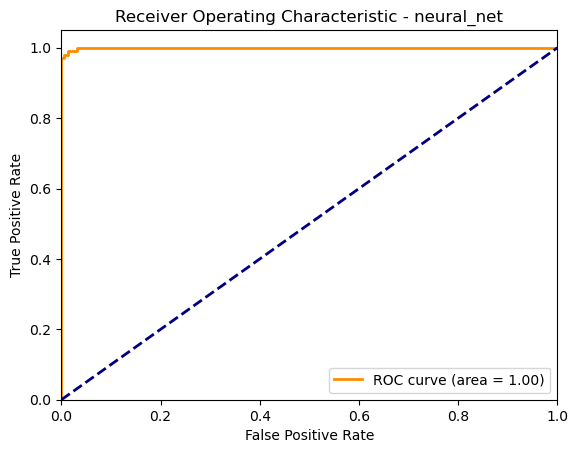

In [211]:
nn = BinaryNeuralNetwork(
    X_selected.shape[1],
    d_hidden,
    n_hidden,
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    lambda_reg=lambda_reg,
)

nn.fit(X_train_selected, y_train_selected, X_val_selected, y_val_selected, plot=True)

y_pred = nn.predict(X_val_selected)
y_pred_proba = nn.predict_proba(X_val_selected)
acc, f1, auc = evaluate(
    "Neural Network", y_val_selected, y_pred, y_pred_proba, plot=True
)

The Neural Network that was trained with manually selected hyperparameters seems to perform well. The AUC score is > 0.999 and the F1 score is around 0.97. This is a great result. Let's see if we can get any better through automatic hyperparameter tuning.


### Automatic Hyperparameter Tuning


In [221]:
param_grid = {
    "n_features": [X_selected.shape[1]],
    "epochs": [10, 20, 30],
    "learning_rate": [0.1, 0.01, 0.001],
    "lambda_reg": [0.01, 0.001, 0.0001],
    "n_hidden_units": [16, 32, 64],
    "n_hidden_layers": [1, 2],
}

Empirical risk estimate for fold 1 / 5, parameter set 1 / 162: 0.17937178235506618
Empirical risk estimate for fold 1 / 5, parameter set 2 / 162: 0.09749003772612995
Empirical risk estimate for fold 1 / 5, parameter set 3 / 162: 0.16144264524436652
Empirical risk estimate for fold 1 / 5, parameter set 4 / 162: 0.2200825854318785
Empirical risk estimate for fold 1 / 5, parameter set 5 / 162: 0.18336376420625866
Empirical risk estimate for fold 1 / 5, parameter set 6 / 162: 0.05750796281763451
Empirical risk estimate for fold 1 / 5, parameter set 7 / 162: 0.1332528674386087
Empirical risk estimate for fold 1 / 5, parameter set 8 / 162: 0.030585370501388133
Empirical risk estimate for fold 1 / 5, parameter set 9 / 162: 0.1315653723145903
Empirical risk estimate for fold 1 / 5, parameter set 10 / 162: 0.0339231794549466
Empirical risk estimate for fold 1 / 5, parameter set 11 / 162: 0.13289131658449313
Empirical risk estimate for fold 1 / 5, parameter set 12 / 162: 0.07541227753289949
Empi

2024-07-30 16:43:30.231 | INFO     | src.training.evaluate:evaluate:46 - Binary Neural Network – Empirical Risk Estimate: 0.001253863512359808, Accuracy: 1.0, F1 score: 1.0, Precision: 1.0, Recall: 1.0, AUC: 1.0
            Pred Neg  Pred Pos
Actual Neg       722         0
Actual Pos         0        78


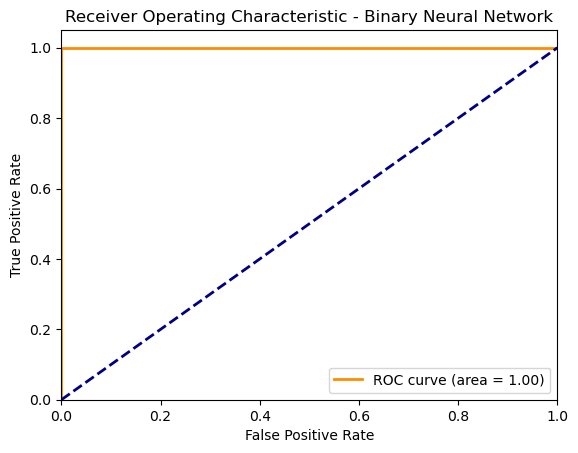

Empirical risk estimate on outer validation set: 0.001253863512359808
Epoch 0: Train Loss: 0.5183960618215971, Val Loss: 0.3538535465618215
Epoch 1: Train Loss: 0.3239201300320103, Val Loss: 0.28366522207261213
Epoch 2: Train Loss: 0.25723895797675744, Val Loss: 0.2382338332447787
Epoch 3: Train Loss: 0.19332091662347184, Val Loss: 0.16709997596626422
Epoch 4: Train Loss: 0.11941719143030119, Val Loss: 0.08135211794485474
Epoch 5: Train Loss: 0.05772738835288998, Val Loss: 0.047888062928585856
Epoch 6: Train Loss: 0.02381688301712503, Val Loss: 0.014980548035548208
Epoch 7: Train Loss: 0.011306029347098547, Val Loss: 0.009754790148432998
Epoch 8: Train Loss: 0.006357333091135221, Val Loss: 0.005364569635933902
Epoch 9: Train Loss: 0.0042412489426540455, Val Loss: 0.0037107412510398877
Epoch 10: Train Loss: 0.003241283007390274, Val Loss: 0.002905220319491467
Epoch 11: Train Loss: 0.0026541891444604544, Val Loss: 0.0024423261402419785
Epoch 12: Train Loss: 0.0022914168228012136, Val Los

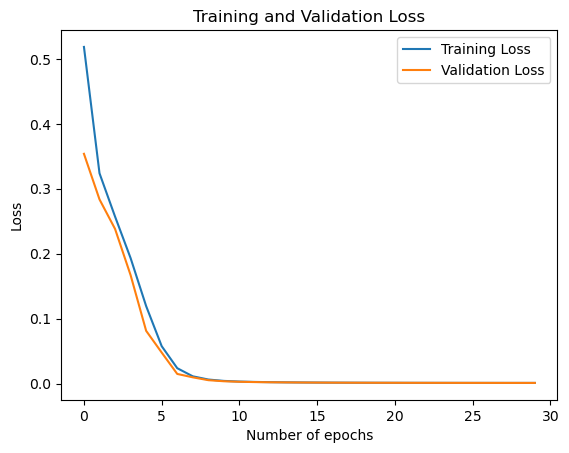

Training complete.
Fitted final model on entire dataset


In [222]:
k = 5

nn_final, nn_params, nn_R_est, nn_acc, nn_f1, nn_auc = select_model(
    X_selected,
    y_selected,
    BinaryNeuralNetwork,
    param_grid,
    k=k,
)

We managed to achieve a perfect model! The AUC is 1.0, which is the best possible result. The precision is 1.0, which means the model is never wrong when it predicts a positive class. The recall is 1.0, which means the model is able to correctly classify all positive cases.

This implies that the Neural Network is slightly better at seperating the data than the Logistic Regression model. This also implies that there are non-linear relationships in the data that the polynomial features were not fully able to capture.


## Conclusion <a id="7"></a>
